In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
from torchvision import datasets
from tqdm import tqdm
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()

# Model Design


Some tips you can use in the model design:

*   Convolution
*   Linear
*   Pooling
*   Batch normalization
*   ReLU
*   Dropout




In [55]:
import torch
import torch.nn as nn

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        ###### TODO : You can design model architechture ######
        self.conv1 = nn.Conv2d(in_channels= 1 , out_channels=32, kernel_size=3, stride=1, padding=1, bias= False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels= 32 , out_channels=64, kernel_size=3, stride=1, padding=1, bias= False)
        self.bn2 = nn.BatchNorm2d(64) 
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels= 64 , out_channels=32, kernel_size=3, stride=1, padding=1, bias= False)
        self.bn3 = nn.BatchNorm2d(32) 
        self.conv4 = nn.Conv2d(in_channels= 32 , out_channels=16, kernel_size=3, stride=1, padding=1, bias= False)
        self.bn4 = nn.BatchNorm2d(16) 
        self.globpool = nn.AvgPool2d(kernel_size=14)  
        self.fc1 = nn.Linear(in_features=16,out_features=64)
        self.fc2 = nn.Linear(64,128) 
        self.fc3 = nn.Linear(128,32)
        self.fc4 = nn.Linear(32,10)

         ######################################################
    def forward(self,x):
        out = self.conv1(x)
        out1 = F.relu(self.bn1(out)) + x
        out1 = self.conv2(out1)
        out2 = F.relu(self.bn2(out1)) + out1
        out2 = self.maxpool(out2)
        out2 = self.conv3(out2)
        out3 = F.relu(self.bn3(out2)) + out2
        out3 = self.conv4(out3)
        out4 = F.relu(self.bn4(out3)) +out3
        out4 = self.globpool(out4)
        out5 = out4.view(-1,16)
        out5 = self.fc1(out5)
        out5 = F.relu(out5)
        out5 = self.fc2(out5)
        out5 = F.relu(out5)
        out5 = self.fc3(out5)
        out5 = F.sigmoid(self.fc4(out5))
        return out5


In [56]:
# Create an instance of the DNN model
net = DNN().cuda()  # Move the model to GPU if available

# Caculating the number of the parameter and the MACs of the model

In [57]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
grad_para = count_parameters(net)
# print(f'Total params: {grad_para / 1e6}M')
summary(net,(1,28,28))

#Compute MACs
from thop import profile
input1 = torch.randn(1,1,28,28).cuda()
MACs, params = profile(net, inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 64, 28, 28]          18,432
       BatchNorm2d-4           [-1, 64, 28, 28]             128
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]          18,432
       BatchNorm2d-7           [-1, 32, 14, 14]              64
            Conv2d-8           [-1, 16, 14, 14]           4,608
       BatchNorm2d-9           [-1, 16, 14, 14]              32
        AvgPool2d-10             [-1, 16, 1, 1]               0
           Linear-11                   [-1, 64]           1,088
           Linear-12                  [-1, 128]           8,320
           Linear-13                   [-1, 32]           4,128
           Linear-14                   

# Configuration

In [58]:
### TODO : You can modify the configuration for model training ###

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = optim.Adam(net.parameters(), lr=0.001)

# The number of batch size.
batch_size = 512

# If no improvement in 'patience' epochs, early stop.
patience  = 10

# The number of training epochs
n_epoch = 100

_exp_name = "N26122246_minist"

# Dataloader

In [59]:


# Select training_set and testing_set (dataset : FashionMNIST )
train_data = datasets.FashionMNIST("data",train= True, download=True,   transform = transforms.ToTensor())

test_data = datasets.FashionMNIST("data",  train= False, download=True, transform = transforms.ToTensor())

# # Number of subprocesses to use for data loading
# num_workers = 0

# Percentage of training set to use as validation
n_valid = 0.2

# Get indices for training_set and validation_set
n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)

split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


In [60]:
# Training data
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  sampler = train_sampler , num_workers=2)

# Validation data
validloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, sampler = valid_sampler, num_workers = 2)

# Test data
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,  num_workers=2)



# Model Training

In [69]:
train_loss_epoch = []
val_loss_epoch = []

best_acc = 0
epoch_counter = 0

for epoch in range(n_epoch):  # loop over the dataset multiple times


    running_loss = 0.0
    epoch_counter += 1

    ################## Training ##################
    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    train_loss_epoch.append(train_loss)


    # Print the information.
    print('========================================================================================================')
    print(f"[ Train | {epoch + 1:03d}/{n_epoch:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    ################## Validition ##################
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for data in tqdm(validloader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = data
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = net(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())
        #break

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    val_loss_epoch.append(valid_loss)


    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epoch:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


     # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch + 1:03d}, saving model")
        torch.save(net.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

print('Finished Training')

[ Train | 001/100 ] loss = 1.54938, acc = 0.86517


100%|██████████| 24/24 [00:03<00:00,  7.98it/s]


[ Valid | 001/100 ] loss = 1.55452, acc = 0.85699
Best model found at epoch 001, saving model
[ Train | 002/100 ] loss = 1.54598, acc = 0.87023


100%|██████████| 24/24 [00:02<00:00,  8.07it/s]


[ Valid | 002/100 ] loss = 1.56994, acc = 0.84413
[ Train | 003/100 ] loss = 1.54406, acc = 0.87134


100%|██████████| 24/24 [00:03<00:00,  8.00it/s]


[ Valid | 003/100 ] loss = 1.55113, acc = 0.86902
Best model found at epoch 003, saving model
[ Train | 004/100 ] loss = 1.54377, acc = 0.87231


100%|██████████| 24/24 [00:02<00:00,  8.01it/s]


[ Valid | 004/100 ] loss = 1.55143, acc = 0.86273
[ Train | 005/100 ] loss = 1.54311, acc = 0.87292


100%|██████████| 24/24 [00:02<00:00,  8.01it/s]


[ Valid | 005/100 ] loss = 1.55495, acc = 0.86018
[ Train | 006/100 ] loss = 1.54292, acc = 0.87461


100%|██████████| 24/24 [00:03<00:00,  7.97it/s]


[ Valid | 006/100 ] loss = 1.54838, acc = 0.86362
[ Train | 007/100 ] loss = 1.54061, acc = 0.87472


100%|██████████| 24/24 [00:03<00:00,  7.92it/s]


[ Valid | 007/100 ] loss = 1.54981, acc = 0.86546
[ Train | 008/100 ] loss = 1.54183, acc = 0.87645


100%|██████████| 24/24 [00:02<00:00,  8.02it/s]


[ Valid | 008/100 ] loss = 1.54857, acc = 0.86621
[ Train | 009/100 ] loss = 1.54108, acc = 0.87604


100%|██████████| 24/24 [00:02<00:00,  8.09it/s]


[ Valid | 009/100 ] loss = 1.54912, acc = 0.86608
[ Train | 010/100 ] loss = 1.53999, acc = 0.87874


100%|██████████| 24/24 [00:02<00:00,  8.13it/s]


[ Valid | 010/100 ] loss = 1.55265, acc = 0.86419
[ Train | 011/100 ] loss = 1.53948, acc = 0.87912


100%|██████████| 24/24 [00:03<00:00,  7.96it/s]


[ Valid | 011/100 ] loss = 1.55512, acc = 0.86615
[ Train | 012/100 ] loss = 1.53913, acc = 0.87934


100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


[ Valid | 012/100 ] loss = 1.54503, acc = 0.87495
Best model found at epoch 012, saving model
[ Train | 013/100 ] loss = 1.54072, acc = 0.87782


100%|██████████| 24/24 [00:02<00:00,  8.20it/s]


[ Valid | 013/100 ] loss = 1.54837, acc = 0.86969
[ Train | 014/100 ] loss = 1.53959, acc = 0.87911


100%|██████████| 24/24 [00:03<00:00,  7.15it/s]


[ Valid | 014/100 ] loss = 1.54621, acc = 0.87395
[ Train | 015/100 ] loss = 1.53851, acc = 0.87997


100%|██████████| 24/24 [00:03<00:00,  7.71it/s]


[ Valid | 015/100 ] loss = 1.57464, acc = 0.84208
[ Train | 016/100 ] loss = 1.54277, acc = 0.87609


100%|██████████| 24/24 [00:03<00:00,  7.89it/s]


[ Valid | 016/100 ] loss = 1.55099, acc = 0.86061
[ Train | 017/100 ] loss = 1.53683, acc = 0.88168


100%|██████████| 24/24 [00:02<00:00,  8.09it/s]


[ Valid | 017/100 ] loss = 1.54347, acc = 0.87657
Best model found at epoch 017, saving model
[ Train | 018/100 ] loss = 1.53814, acc = 0.87829


100%|██████████| 24/24 [00:02<00:00,  8.22it/s]


[ Valid | 018/100 ] loss = 1.54391, acc = 0.87960
Best model found at epoch 018, saving model
[ Train | 019/100 ] loss = 1.53824, acc = 0.87898


100%|██████████| 24/24 [00:03<00:00,  7.88it/s]


[ Valid | 019/100 ] loss = 1.55563, acc = 0.86370
[ Train | 020/100 ] loss = 1.53682, acc = 0.88203


100%|██████████| 24/24 [00:02<00:00,  8.01it/s]


[ Valid | 020/100 ] loss = 1.55076, acc = 0.86620
[ Train | 021/100 ] loss = 1.53642, acc = 0.88214


100%|██████████| 24/24 [00:03<00:00,  7.91it/s]


[ Valid | 021/100 ] loss = 1.54188, acc = 0.88049
Best model found at epoch 021, saving model
[ Train | 022/100 ] loss = 1.53732, acc = 0.88124


100%|██████████| 24/24 [00:03<00:00,  7.66it/s]


[ Valid | 022/100 ] loss = 1.54370, acc = 0.87783
[ Train | 023/100 ] loss = 1.53352, acc = 0.88651


100%|██████████| 24/24 [00:03<00:00,  7.96it/s]


[ Valid | 023/100 ] loss = 1.54981, acc = 0.86887
[ Train | 024/100 ] loss = 1.53299, acc = 0.88860


100%|██████████| 24/24 [00:02<00:00,  8.03it/s]


[ Valid | 024/100 ] loss = 1.54442, acc = 0.87459
[ Train | 025/100 ] loss = 1.53687, acc = 0.88235


100%|██████████| 24/24 [00:02<00:00,  8.02it/s]


[ Valid | 025/100 ] loss = 1.54406, acc = 0.87650
[ Train | 026/100 ] loss = 1.53517, acc = 0.88348


100%|██████████| 24/24 [00:03<00:00,  7.79it/s]


[ Valid | 026/100 ] loss = 1.55020, acc = 0.86222
[ Train | 027/100 ] loss = 1.53567, acc = 0.88510


100%|██████████| 24/24 [00:03<00:00,  7.81it/s]


[ Valid | 027/100 ] loss = 1.54933, acc = 0.86600
[ Train | 028/100 ] loss = 1.53628, acc = 0.88360


100%|██████████| 24/24 [00:03<00:00,  7.76it/s]


[ Valid | 028/100 ] loss = 1.54347, acc = 0.87440
[ Train | 029/100 ] loss = 1.53388, acc = 0.88486


100%|██████████| 24/24 [00:02<00:00,  8.14it/s]


[ Valid | 029/100 ] loss = 1.54334, acc = 0.87315
[ Train | 030/100 ] loss = 1.53471, acc = 0.88481


100%|██████████| 24/24 [00:02<00:00,  8.27it/s]


[ Valid | 030/100 ] loss = 1.54703, acc = 0.86779
[ Train | 031/100 ] loss = 1.53402, acc = 0.88708


100%|██████████| 24/24 [00:02<00:00,  8.59it/s]


[ Valid | 031/100 ] loss = 1.56375, acc = 0.84784
[ Train | 032/100 ] loss = 1.53544, acc = 0.88414


100%|██████████| 24/24 [00:02<00:00,  8.23it/s]

[ Valid | 032/100 ] loss = 1.54864, acc = 0.87506
No improvment 10 consecutive epochs, early stopping
Finished Training


# Model Testing

Your test accuracy  shoud be greater than 85%

In [70]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if use_gpu:
            images, labels = images.cuda(),labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 86 %


# Plot the train/val Loss curve

# Plot the train/val loss curve

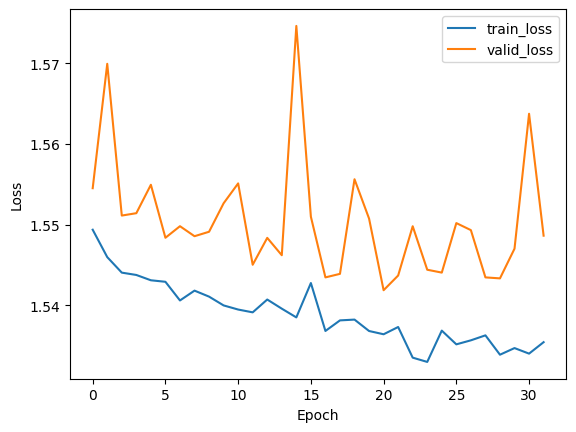

In [71]:
from matplotlib import pyplot as plt
### TODO : Please plot the rain/val loss curve ###


plt.plot(train_loss_epoch, label = 'train_loss')
plt.plot(val_loss_epoch, label = 'valid_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
###########################################################

## Downloading ".onnx file" , and using  Netron to visualize the model


Save the model in .onnx format


In [67]:
# Some standard imports
import io
import torch.utils.model_zoo as model_zoo
import torch.onnx

trained_net = DNN().cuda()

input_shape = torch.randn(1,1,28,28).cuda()
trained_net_weight = torch.load("N26122246_minist_best.ckpt")
trained_net.load_state_dict(trained_net_weight,strict=False)
trained_net.eval()

### TODO : export your model in .onnx format ###
torch.onnx.export( trained_net,
                  input_shape,
                  "N26122246_fashion_mnist.onnx",
                  opset_version=10,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})



https://netron.app/